# Global indicator project - Phoenix, Arizona


This notebook provides a process to create public transit points using UrbanAccess and Pandas(from UrbanSim).

- Input data format, including which tables, which columns, which order and handling of nulls - you'll need to customise this for each city.  A handy guide to the format of GTFS fields is [here](https://developers.google.com/transit/gtfs/reference/#tripstxt).
- Work out how stops for a mode can be identified; i.e. by agency_id (e.g. in Melbourne the bus, train and tram modes have different agencies, by route_type (e.g. rail in Sydney) or by route_color (e.g. bus in Sydney).  Update stop_analysis for stop identification.
- Check if train stations are whole stations or platforms with a parent station (like Sydney) and modify scripts accordingly.
- For each mode and state check the number of frequent stops by date, sometimes the number will drop off because data is not yet loaded into the timetable, modify the end date accordingly.


## Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Downloading GTFS data
- Loading GTFS data into a UrbanAccess transit data object

For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html



In [139]:
import pandas as pd
import pandana as pdna
import geopandas as gpd
import os
import time
import networkx as nx
import osmnx as ox
import numpy as np

import calendar
import datetime

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

from shapely.geometry import shape,Point, LineString, Polygon

%matplotlib inline

In [3]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [4]:
suffix = '_201905'

place = 'phoenix' 

region = 'Arizona, USA' # study region name

studyregion = 'Phoenix, Arizona, USA'

# configure filenames to save/load POI and network datasets
OSM_folder = '../data/OSM'
gtfs_folder = '../data/Transport'

gtfs_filepath = '../data/Transport/gtfs_phx/stops.txt'

In [5]:
# get bounding box from study region boundary shapefile

#Bounding box formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
bbox = (-113.3338,32.505,-111.0399,34.0481) #bounding box for Maricopa County

You can generate a bounding box by going to http://boundingbox.klokantech.com/ and selecting the CSV format.

# Download or load GTFS data into an UrbanAccess transit data frame

Load the GTFS feeds (currently a series of text files stored on disk) into a combined network of Pandas DataFrames.

- You can specify one feed or multiple feeds that are inside a root folder using the `gtfsfeed_path` parameter. If you want to aggregate multiple transit networks together, all the GTFS feeds you want to aggregate must be inside of a single root folder.
- Turn on `validation` and set a bounding box with the `remove_stops_outsidebbox` parameter turned on to ensure all your GTFS feed data are within a specified area.


Phoenix GTFS data from transitfeed.com https://transitfeeds.com/p/valley-metro/68

In [6]:
gtfs_url = 'https://www.phoenixopendata.com/dataset/3eae9a4a-98b9-40c8-8df7-8c00c1756235/resource/28ccc0a5-49c8-495c-b91f-193de5ce2cb7/download/googletransit.zip'
gtfs_provider = 'Phx Valley metro'

In [7]:
def get_gtfs_dfs(gtfs_filepath, bbox, gtfs_url, gtfs_provider):
    if os.path.isfile(gtfs_filepath):
        loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=gtfs_folder,
                                           validation=True,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=True,
                                           append_definitions=True)
    
    
    else:
        feeds.add_feed(add_dict={gtfs_provider: gtfs_url})
        feeds.to_dict()
        gtfsfeeds.download(data_folder=gtfs_folder, feed_name='gtfs')
        
        loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=gtfs_folder,
                                           validation=True,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=True,
                                           append_definitions=True)
        
    return loaded_feeds

In [8]:
loaded_feeds = get_gtfs_dfs(gtfs_filepath, bbox, gtfs_url, gtfs_provider)

GTFS text file header whitespace check completed. Took 13.13 seconds
--------------------------------
Processing GTFS feed: gtfs_phx
The agency.txt or agency_id column was not found. The unique agency id: gtfs_phx was generated using the name of the folder containing the GTFS feed text files.
Unique agency id operation complete. Took 0.13 seconds
Unique GTFS feed id operation complete. Took 0.02 seconds
Records: {}
     stop_id  stop_code        stop_name  stop_desc   stop_lat    stop_lon  \
7800    9730    17112.0  2nd Av & 5th St        NaN  32.382707 -112.872186   

      zone_id  stop_url  location_type parent_station unique_agency_id  \
7800      NaN       NaN              0            NaN         gtfs_phx   

     unique_feed_id  
7800     gtfs_phx_1  
Removed identified stops that are outside of bounding box.
gtfs_phx GTFS feed stops: coordinates are in northwest hemisphere. Latitude = North (90); Longitude = West (-90).
Appended route type to stops
Appended route type to stop_t

### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

In [9]:
loaded_feeds.stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,unique_agency_id,unique_feed_id,route_type,location_type_desc
0,100,16619.0,Bell Rd & 44th St,NaN,33.640488,-111.986041,NaN,NaN,0,NaN,gtfs_phx,gtfs_phx_1,3.0,stop
1,1002,15234.0,Alice Av & 66th Dr,NaN,33.563533,-112.200947,NaN,NaN,0,NaN,gtfs_phx,gtfs_phx_1,3.0,stop
2,10021,16877.0,3rd St & Taylor St,NaN,33.453085,-112.070037,NaN,NaN,0,NaN,gtfs_phx,gtfs_phx_1,3.0,stop
3,1003,13532.0,Atlanta Av & 11th Av,NaN,33.400036,-112.085804,NaN,NaN,0,NaN,gtfs_phx,gtfs_phx_1,3.0,stop
4,1004,14926.0,Baseline Rd & 19th Av,NaN,33.377644,-112.098529,NaN,NaN,0,NaN,gtfs_phx,gtfs_phx_1,3.0,stop


Quickly view the transit stop locations

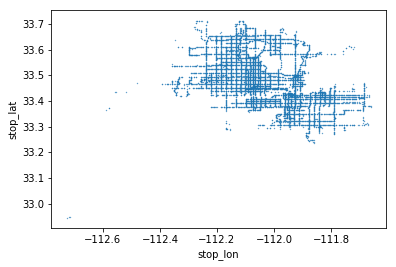

In [10]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

## Create bus_30min_stops analysis
## Which stops qualify on a daily basis?
- First service departs before 7.30am
- Last service departs on or after 6.30pm
- Has a maximum inter-departure time less than or equal to 30 minutes
- It is difficult (especially in some cities) to determine what constitutes a “normal weekday” – some modes run different timetables on different weekdays, and timetable changes are introduced frequently.

Note: in Phoenix, the subway and the bus system are operated by the same agency Valley Metro. There are only two types of routes specified, type 3 (bus) and type 0 (valley metro rail & sky train). We deal with Bus service first.

In [11]:
#select daytime bus service
loaded_feeds.stop_times = loaded_feeds.stop_times.sort_values(['trip_id', 'stop_sequence'])
loaded_feeds.stop_times = loaded_feeds.stop_times[(loaded_feeds.stop_times['departure_time'] >= '07:00:00') & (loaded_feeds.stop_times['departure_time'] <= '19:00:00')]	

In [12]:
#select stops with ealiest service before 7:30am, and lastest stop before 18:30pm. groupby stop id
stop_first_peak_service_bus = (loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.stop_id).departure_time.min() <= '07:30:00')

stop_last_peak_service_bus = (loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.stop_id).departure_time.max() >= '18:30:00')

loaded_feeds.stop_times = loaded_feeds.stop_times.set_index('stop_id') #set stop_id as index columns

loaded_feeds.stop_times = loaded_feeds.stop_times[(stop_first_peak_service_bus) & (stop_last_peak_service_bus)]

/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [13]:
#sort the departure time and stop id
loaded_feeds.stop_times['stopid'] = loaded_feeds.stop_times.index
loaded_feeds.stop_times = loaded_feeds.stop_times.sort_values(['departure_time', 'stopid'])

In [14]:
#lag departure time to define the next departure time
loaded_feeds.stop_times['next_departure_time'] = loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.index).departure_time.shift(-1) 
loaded_feeds.stop_times[['next_departure_time', 'departure_time']].sort_index().head()

,next_departure_time,departure_time
stop_id,,
100,09:47:00,09:20:00
100,13:21:00,13:21:00
100,10:20:00,10:17:00
100,10:17:00,10:17:00
100,10:17:00,10:17:00


In [15]:
#convert time object(string) to datetime formate
loaded_feeds.stop_times['next_departure_time'] = pd.to_datetime(loaded_feeds.stop_times['next_departure_time'])
loaded_feeds.stop_times['departure_time'] = pd.to_datetime(loaded_feeds.stop_times['departure_time'])

# convert datetime to minutes for calculating the interval time in minutes
loaded_feeds.stop_times['departure_time_minutes'] = (loaded_feeds.stop_times['departure_time'].dt.hour * 60) + loaded_feeds.stop_times['departure_time'].dt.minute
loaded_feeds.stop_times['next_departure_time_minutes'] = (loaded_feeds.stop_times['next_departure_time'].dt.hour * 60) + loaded_feeds.stop_times['next_departure_time'].dt.minute

# calculate the interval time to each stops
loaded_feeds.stop_times['interval_minutes'] = loaded_feeds.stop_times['next_departure_time_minutes'] - loaded_feeds.stop_times['departure_time_minutes']

# Find maximum interval between services for stops with a service before 7.30am and after 6.30pm
#max_interval <= '00:30:00' (groupby stops)
loaded_feeds.stop_times = loaded_feeds.stop_times[loaded_feeds.stop_times.groupby(loaded_feeds.stop_times.index).interval_minutes.max() <= 30]

/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Now we get the stops in the stop_times dataframe with daytime services and services before 7.30am and after 6.30pm with maximum interval less than or equal to 30min.

we need to select only the bus service.

In [ ]:
loaded_feeds.stops = loaded_feeds.stops.set_index('stop_id')
stop_times_stops = pd.merge(left=loaded_feeds.stops, right=loaded_feeds.stop_times, how='right', left_index=True, right_index=True)
stop_30_mins_bus = stop_times_stops[['stop_name', 'stop_desc', 'stop_lat', 'stop_lon', 'location_type', 'parent_station',
       'route_type_x', 'location_type_desc', 'trip_id', 'arrival_time', 'departure_time', 'next_departure_time',
       'stop_sequence', 'stopid', 'departure_time_minutes', 'next_departure_time_minutes', 'interval_minutes']]

#select route type 3 as bus services
stop_30_mins_bus = stop_30_mins_bus[stop_30_mins_bus['route_type_x'] == 3]

#select route type 0 as the valley metro line service, sky train is also identified as the type 0 service, but it is excluded after the frequency criteria
stop_30_mins_metro_rail = stop_30_mins_bus[stop_30_mins_bus['route_type_x'] == 0]

In [19]:
# set up the geometry 
stop_30_mins_bus['geometry'] = stop_30_mins_bus.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

## validate the stops_analysis criteria

In [20]:
# daily services
stop_30_mins_bus.departure_time.min(), stop_30_mins_bus.departure_time.max()

(Timestamp('2019-06-19 07:00:00'), Timestamp('2019-06-19 19:00:00'))

In [21]:
# First service departs before 7.30am
stop_30_mins_bus.groupby(stop_30_mins_bus.index).departure_time.min().max()

Timestamp('2019-06-19 07:29:00')

In [22]:
# Last service departs on or after 6.30pm
stop_30_mins_bus.groupby(stop_30_mins_bus.index).departure_time.max().min()

Timestamp('2019-06-19 18:30:00')

In [23]:
# Has a maximum inter-departure time less than or equal to 30 minutes
stop_30_mins_bus.interval_minutes.max()

30.0

In [24]:
# bus stops, route type 3
stop_30_mins_bus.route_type_x.unique()

array([3.])

## Calendar setup
## How do we define a “normal weekday”?
- Normal weekdays: Monday, Tuesday, Wednesday, Thursday, Friday 

- Stops that are “frequent” stops on 90% or more of these dates (i.e. we don’t look specifically at public holidays) are deemed to be “frequent” stops on a “normal weekday”

builds a table of dates that that a stop is a 30-minute frequency stop, and calculates the number of days (as a denominator) by day of week that the stop is in operation.  It then creates a new table with only those stops that have a weekday_pcent (percentage of weekdays that meet the criteria) of more than 90%.

### 1. identify feeds start and end dates that that a stop is a 30-minute frequency stop

In [245]:
# generate a table or dataframe with all dates for the 30 min frequency stops
trips_stop_30_mins_bus = pd.merge(left=stop_30_mins_bus, right=loaded_feeds.trips, how='left', left_on='trip_id', right_on='trip_id')
calendar_stop_30_mins_bus = pd.merge(left=trips_stop_30_mins_bus, right=loaded_feeds.calendar, how='left', left_on='service_id', right_on='service_id')


In [246]:
#get the stop id with dates and dows
calendar_stop_30_mins_bus = calendar_stop_30_mins_bus[['stopid', 'service_id', 'start_date', 'end_date', 'monday',
       'tuesday', 'wednesday', 'thursday', 'friday', 'stop_lat', 'stop_lon', 'geometry']].sort_values(['stopid', 'service_id', 'start_date'])

In [247]:
#exclude weekends
searchfor = ['Saturday', 'Sunday']
calendar_stop_30_mins_bus = calendar_stop_30_mins_bus[~calendar_stop_30_mins_bus.service_id.str.contains('|'.join(searchfor))]

In [248]:
# sort the data by stopid and serviceid
calendar_stop_30_mins_bus = calendar_stop_30_mins_bus.groupby(by=['stopid', 'start_date', 'end_date']).max()
calendar_stop_30_mins_bus = calendar_stop_30_mins_bus.reset_index(level=['start_date', 'end_date'])

In [250]:
calendar_stop_30_mins_bus.columns

Index(['start_date', 'end_date', 'friday', 'monday', 'service_id', 'stop_lat',
       'stop_lon', 'thursday', 'tuesday', 'wednesday'],
      dtype='object')

### 2. calculates the number of normal weekdays

In [251]:
start_date = pd.to_datetime(calendar_stop_30_mins_bus['start_date'].min(), format='%Y%m%d')
end_date = pd.to_datetime(calendar_stop_30_mins_bus['end_date'].max(), format='%Y%m%d')
(start_date, end_date)

(Timestamp('2019-04-03 00:00:00'), Timestamp('2019-07-19 00:00:00'))

In [265]:
# count total number of weekdays not considering the public holidya or specific service exclusion day
tot_normal_weekdays = np.busday_count(start_date.date(), end_date.date())
tot_normal_weekdays

77

### 3. calculates the number of weekdays that the frequent stop is in operation

In [253]:
# count the maximum number of weekdays a stop_id could be a 30 minute stop by dow
calendar_stop_30_mins_bus['start_date'] = pd.to_datetime(calendar_stop_30_mins_bus['start_date'], format='%Y%m%d')
calendar_stop_30_mins_bus['end_date'] = pd.to_datetime(calendar_stop_30_mins_bus['end_date'], format='%Y%m%d')

In [254]:
# weekdays by dow count
def weekday_count(start_date, end_date):
    week = {}
    for i in range((end_date - start_date).days):
        day = calendar.day_name[(start_date + datetime.timedelta(days=i+1)).weekday()]
        week[day] = week[day] + 1 if day in week else 1
    return week

weekday_count(start_date, end_date)

{'Thursday': 16,
 'Friday': 16,
 'Saturday': 15,
 'Sunday': 15,
 'Monday': 15,
 'Tuesday': 15,
 'Wednesday': 15}

In [255]:
calendar_stop_30_mins_bus['Monday'] = calendar_stop_30_mins_bus.apply(lambda row: weekday_count(row['start_date'], row['end_date'])['Monday'] if row['monday']==1 else row['monday'], axis=1)

calendar_stop_30_mins_bus['Tuesday'] = calendar_stop_30_mins_bus.apply(lambda row: weekday_count(row['start_date'], row['end_date'])['Tuesday'] if row['tuesday']==1 else row['tuesday'], axis=1)
calendar_stop_30_mins_bus['Wednesday'] = calendar_stop_30_mins_bus.apply(lambda row: weekday_count(row['start_date'], row['end_date'])['Wednesday'] if row['wednesday']==1 else row['wednesday'], axis=1)

calendar_stop_30_mins_bus['Thursday'] = calendar_stop_30_mins_bus.apply(lambda row: weekday_count(row['start_date'], row['end_date'])['Thursday'] if row['thursday']==1 else row['thursday'], axis=1)
calendar_stop_30_mins_bus['Friday'] = calendar_stop_30_mins_bus.apply(lambda row: weekday_count(row['start_date'], row['end_date'])['Friday'] if row['friday']==1 else row['friday'], axis=1)


In [262]:
bus_stop_dow = calendar_stop_30_mins_bus[['Monday', 'Tuesday',	'Wednesday', 'Thursday', 'Friday']].groupby(calendar_stop_30_mins_bus.index).sum()

,Monday,Tuesday,Wednesday,Thursday,Friday
stopid,,,,,
100,14,15,15,16,14
1002,14,15,15,16,14
1003,14,15,15,16,14
1004,14,15,15,16,14
1005,14,15,15,16,14


In [263]:
bus_stop_dow['30min_maxi_weekdays'] = bus_stop_dow.sum(1)

In [270]:
bus_stop_dow['tot_normal_weekdays'] = tot_normal_weekdays
bus_stop_dow['30min_weekday_pcent'] = 100*bus_stop_dow['30min_maxi_weekdays'] / bus_stop_dow['tot_normal_weekdays']
bus_stop_dow.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,30min_maxi_weekdays,tot_normal_weekdays,30min_weekday_pcent
stopid,,,,,,,,
100,14,15,15,16,14,74,77,96.103896
1002,14,15,15,16,14,74,77,96.103896
1003,14,15,15,16,14,74,77,96.103896
1004,14,15,15,16,14,74,77,96.103896
1005,14,15,15,16,14,74,77,96.103896


In [310]:
stop_30_mins_bus_final = pd.merge(left=loaded_feeds.stops[['stop_lat',	'stop_lon']], right=bus_stop_dow, how='right', left_index=True, right_index=True)
stop_30_mins_bus_final['geometry'] = stop_30_mins_bus_final.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)

In [314]:
stop_30_mins_bus_final

,stop_lat,stop_lon,Monday,Tuesday,Wednesday,Thursday,Friday,30min_maxi_weekdays,tot_normal_weekdays,30min_weekday_pcent,geometry
stopid,,,,,,,,,,,
100,33.640488,-111.986041,14,15,15,16,14,74,77,96.103896,POINT (-111.9860407 33.64048784)
1002,33.563533,-112.200947,14,15,15,16,14,74,77,96.103896,POINT (-112.2009471 33.56353253)
1003,33.400036,-112.085804,14,15,15,16,14,74,77,96.103896,POINT (-112.0858039 33.4000364)
1004,33.377644,-112.098529,14,15,15,16,14,74,77,96.103896,POINT (-112.0985289 33.377644)
1005,33.377511,-112.133145,14,15,15,16,14,74,77,96.103896,POINT (-112.133145 33.37751097)
1006,33.377613,-112.082136,14,15,15,16,14,74,77,96.103896,POINT (-112.0821356 33.37761273)
1007,33.378079,-111.955422,14,15,15,16,14,74,77,96.103896,POINT (-111.9554215 33.37807901)
1008,33.377609,-112.091398,14,15,15,16,14,74,77,96.103896,POINT (-112.0913979 33.37760888)
1009,33.377545,-112.118008,14,15,15,16,14,74,77,96.103896,POINT (-112.1180078 33.37754533)
